

When calculating S/N or exposure time, consider this both from the point of view of an imaging instrument (that integrates over wavelengths) and also a spectrograph (that does not). For the spectrograph case, you would produce S/N or exposure time per wavelength pixel: you could include in your instrument definition a parameter for the "dispersion" (e.g A/pixel).

Continue by generalizing your instrument routine to return a pixel size (arcsec/pixel) and readout noise for an input instrument name (or, if you haven't generalized to using an instrument name yet, from supplied pixel scale and readout noise).  Include readout noise in your routines to calculate S/N and exposure time; to get the appropriate number of pixels for the readout noise term, you'll have to input the aperture radius (e.g the seeing FWHM) to use for a given observation. For the spectrograph case, note that the number of pixels relevant for readout noise would just be 1D depending on the seeing and the pixel scale, as opposed to the 2D case for imaging.

Make sure you to validate your results and document this validation! For example, work out the S/N as f(t) and t as f(S/N) by hand for the test cases you have previously used and compare to your numerical result, and make sure they agree. Make sure to report these.


In [1]:
import os
import sys
notebook_directory = os.getcwd()
sys.path.append(notebook_directory)
import ExpTime_Calc as EC

In [2]:
# Initialize the SED class
model = EC.SED(mag = 20, temperature = 9700)

# Create the spectrum
wavelength,spectrum = model.photon_spectrum()

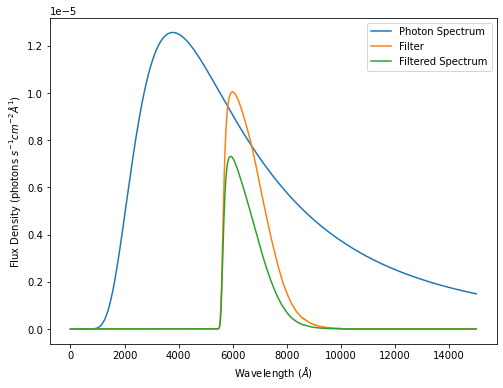

In [3]:
# Initialize the BandPass class
Vband = EC.BandPass('R')

# Filter the spectrum with the filter response
filtered_spectrum = Vband.filter_SED(wavelength, spectrum,plot=True)

In [8]:
model_SED = EC.SED(mag = 10, temperature = 9700)

timstelescope = EC.Telescope(diameter=60,diameter_units='mm',focal_length=600,foc_len_units='mm') #create telescope

LasCruces = EC.atmosphere('default',seeing=1) #create atmosphere conditions

camera = EC.detector(QE=0.8,px_size=5, read_noise=5) #create detector

In [9]:
observation = EC.Observation(model_SED,                              #initialize observation
                              filter='V',telescope=timstelescope,
                              atmosphere=LasCruces,detector=camera)

1679.71 photons per second
 
5.97 seconds for SNR=100


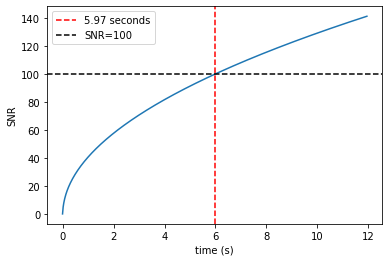

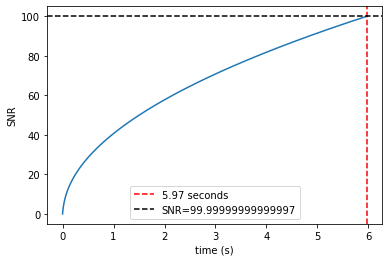

In [11]:
snr = EC.Signal_to_Noise(observation,SNR=100)

time = snr.calc_exptime(plot=True) #calculate time for desired SNR

snr_value = snr.calc_SNR(time,plot=True) #calculate SNR from calculated time


# Spectrograph:

 
18.25 seconds for SNR=50


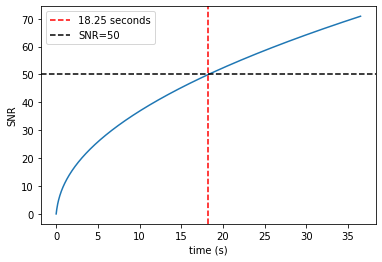

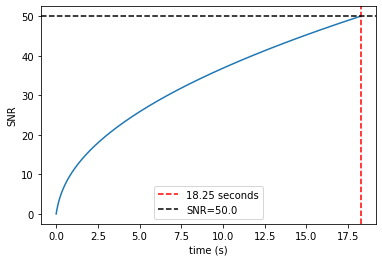

In [12]:
model_SED = EC.SED(mag = 10, temperature = 9700)

timstelescope = EC.Telescope(diameter=60,diameter_units='cm',focal_length=600,foc_len_units='mm') #create telescope

LasCruces = EC.atmosphere('default',seeing=1) #create atmosphere conditions

camera = EC.detector(QE=0.8,px_size=5, read_noise=5,instrument_type='spectroscopy',dispersion = 1) #create detector

observation = EC.Observation(model_SED,                              #initialize observation
                              filter='V',telescope=timstelescope,
                              atmosphere=LasCruces,detector=camera)

snr = EC.Signal_to_Noise(observation,SNR=50,wavelength=5500)

time = snr.calc_exptime(plot=True) #calculate time for desired SNR

snr_value = snr.calc_SNR(time,plot=True) #calculate SNR from calculated time